In [1]:
import pandas as pd
import numpy as np
import altair as alt
import pyarrow.parquet as pq
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import make_scorer, precision_score

from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

import warnings

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

import altair as alt

import nx_altair as nxa


# from plotnine.themes import theme_538

# Model Interpretability

Our Logistic Regression model achieved high precision when predicting instances of 'No Dementia.' This aligns with our objective of minimizing false positives, which is particularly crucial in the context of long-term care insurance underwriting. To enhance the interpretability of the model, we performed a feature importance analysis using Recursive Feature Elimination (RFE). Given the initial complexity of the model with 50,281 features, understanding the contribution of each feature was challenging. The RFE process allowed us to identify the most significant features, contributing to a more streamlined and interpretable model.  

Literature searches uncovered substantial research in the area of dementia and gene expression. These studies have identified multiple genes associated with the onset of dementia. As part of our interpretability analysis of the model, we compared the most important features/genes identified as the most crucial contributors through RFE with those known to be associated with dementia.  

To supplement our analysis, we examined gene descriptions to identify related genes or genes with similar functions. Additionally, we sought to visualize changes in the gene expression levels between non-dementia and dementia patients. This holistic approach enhances our model's interpretability and may provide insights into the potential biological mechanisms underlying dementia onset.


# Data acquisition

## Helper Functions/Variables

## Import External Data Files

In [2]:
# import gene RNAseq data file from a parquet formated file
log_reg_selected_features = pd.read_csv('../results/tables/selected_genes.csv')

In [3]:
# The datafrasme below are the features identified as important features/contributors to the ML model.
log_reg_selected_features

,gene_id,chromosome,gene_entrez_id,gene_symbol,gene_name,Importance
0,499304664,1,645520,FAM138A,"family with sequence similarity 138, member A",-0.002135
1,499304666,1,79504,OR4G4P,"olfactory receptor, family 4, subfamily G, mem...",-0.003320
2,499304667,1,403263,OR4G11P,"olfactory receptor, family 4, subfamily G, mem...",-0.002772
3,499304686,1,105378947,LOC105378947,proline-rich extensin-like protein EPR1,-0.003186
4,499304698,1,105378580,LOC105378580,uncharacterized LOC105378580,0.001795
...,...,...,...,...,...,...
3617,499354987,Y,100418739,DNM1P48,DNM1 pseudogene 48,-0.002402
3618,499355004,Y,386744,CDY22P,"chromodomain protein, Y-linked 22 pseudogene",-0.003050
3619,499355018,Y,360188,CYCSP48,"cytochrome c, somatic pseudogene 48",0.002175
3620,499355022,Y,286573,TPTE2P4,transmembrane phosphoinositide 3-phosphatase a...,0.002023


In [4]:
# Read an external file containing features/genes identified as important to dementia.
# This are literature identified gene candidates
dementia_genes = pd.read_csv('../data/external/dementia_associated_genes.csv')
dementia_genes

,#,Symbol,Description,Category,Score
0,1,PSEN1,Presenilin 1,Protein Coding,470.53
1,2,MAPT,Microtubule Associated Protein Tau,Protein Coding,459.50
2,3,GBA1,Glucosylceramidase Beta 1,Protein Coding,51.97
3,4,APP,Amyloid Beta Precursor Protein,Protein Coding,51.73
4,5,APOE,Apolipoprotein E,Protein Coding,45.04
...,...,...,...,...,...
116,117,ACE,Angiotensin I Converting Enzyme,Protein Coding,16.39
117,118,SOD1,Superoxide Dismutase 1,Protein Coding,16.31
118,119,MAOA,Monoamine Oxidase A,Protein Coding,16.30
119,120,HTR1A,5-Hydroxytryptamine Receptor 1A,Protein Coding,16.22


In [5]:
# Read an external file containig all features/genes in the original expression data set
# This are all >50,000 genes
all_geges_df = pd.read_csv('../results/tables/all_genes_table.csv')


In [6]:
all_geges_df

,gene_id,chromosome,gene_entrez_id,gene_symbol,gene_name,Importance
0,499304660,1,100287102,DDX11L1,DEAD/H (Asp-Glu-Ala-Asp/His) box helicase 11 l...,-0.001249
1,499304661,1,653635,WASH7P,WAS protein family homolog 7 pseudogene,-0.000334
2,499304662,1,102466751,MIR6859-1,microRNA 6859-1,0.000349
3,499304663,1,100302278,MIR1302-2,microRNA 1302-2,0.001220
4,499304664,1,645520,FAM138A,"family with sequence similarity 138, member A",-0.002135
...,...,...,...,...,...,...
50276,499355059,MT,4541,ND6,NADH dehydrogenase subunit 6,0.000841
50277,499355060,MT,4556,TRNE,tRNA-Glu,-0.001161
50278,499355061,MT,4519,CYTB,cytochrome b,0.001798
50279,499355062,MT,4576,TRNT,tRNA-Thr,-0.001029


In [8]:
# import changes in expression

In [7]:
expression_delta_values = pd.read_csv('../results/tables/expression_delta_values.csv')

In [8]:
expression_delta_values

,Unnamed: 0,expression_delta
0,499304660,0.015804
1,499304661,0.280732
2,499304662,0.002930
3,499304663,0.000590
4,499304664,0.009648
...,...,...
50276,499355059,1.898187
50277,499355060,0.069123
50278,499355061,32.857833
50279,499355062,0.032852


In [9]:
# Merge changes in expression with the main gene dataframe
# Renaming a columns
expression_delta_values.rename(columns={'Unnamed: 0': 'gene_id'}, inplace=True)


In [10]:
# Merge DataFrames based on the 'gene_id' column
all_geges_df = pd.merge(all_geges_df, expression_delta_values, on='gene_id', how='inner')

In [11]:
all_geges_df

,gene_id,chromosome,gene_entrez_id,gene_symbol,gene_name,Importance,expression_delta
0,499304660,1,100287102,DDX11L1,DEAD/H (Asp-Glu-Ala-Asp/His) box helicase 11 l...,-0.001249,0.015804
1,499304661,1,653635,WASH7P,WAS protein family homolog 7 pseudogene,-0.000334,0.280732
2,499304662,1,102466751,MIR6859-1,microRNA 6859-1,0.000349,0.002930
3,499304663,1,100302278,MIR1302-2,microRNA 1302-2,0.001220,0.000590
4,499304664,1,645520,FAM138A,"family with sequence similarity 138, member A",-0.002135,0.009648
...,...,...,...,...,...,...,...
50276,499355059,MT,4541,ND6,NADH dehydrogenase subunit 6,0.000841,1.898187
50277,499355060,MT,4556,TRNE,tRNA-Glu,-0.001161,0.069123
50278,499355061,MT,4519,CYTB,cytochrome b,0.001798,32.857833
50279,499355062,MT,4576,TRNT,tRNA-Thr,-0.001029,0.032852


In [12]:
# Make a set containing the gene symbols for all original geatures/genes
all_gens_set = set(all_geges_df['gene_symbol'])

In [13]:
# Check the number of genes in the set
len(all_gens_set)

50281

# Data Preprocessing

In [14]:
# Create a set of the gene symbols in genes from literature reviews
literature_symbols = set(dementia_genes['Symbol'])
len(literature_symbols)

121

In [15]:
# what are the number of genes on the literature_symbols are in the expression data set
# genes in commun between literature review and the gene expression data
len(all_gens_set.intersection(literature_symbols))

115

115 of the literature identified genes are present in the complete set of feature genes

In [16]:
# genes identified as important features on the ML model analysis
model_symbols = set(log_reg_selected_features['gene_symbol'])
len(model_symbols)

3622

In [17]:
# important feature geenes that are also part of the literature identified genes
model_literature_commun_genes = model_symbols.intersection(literature_symbols)
model_literature_commun_genes

{'DRD2', 'NGF', 'SLC6A3'}

In [18]:
# commun genes info
model_literature_commun_genes_df = log_reg_selected_features[log_reg_selected_features['gene_symbol'].isin(model_literature_commun_genes)]
model_literature_commun_genes_df

,gene_id,chromosome,gene_entrez_id,gene_symbol,gene_name,Importance
163,499306944,1,4803,NGF,nerve growth factor (beta polypeptide),0.002468
949,499318037,5,6531,SLC6A3,solute carrier family 6 (neurotransmitter tran...,0.003086
2113,499334184,11,1813,DRD2,dopamine receptor D2,0.002671


In [19]:
# add a source column to identify how the feature/gene was selected
model_literature_commun_genes_df['source'] = 'literature genes'
model_literature_commun_genes_df

/tmp/ipykernel_2095908/2071866739.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_literature_commun_genes_df['source'] = 'literature genes'


,gene_id,chromosome,gene_entrez_id,gene_symbol,gene_name,Importance,source
163,499306944,1,4803,NGF,nerve growth factor (beta polypeptide),0.002468,literature genes
949,499318037,5,6531,SLC6A3,solute carrier family 6 (neurotransmitter tran...,0.003086,literature genes
2113,499334184,11,1813,DRD2,dopamine receptor D2,0.002671,literature genes


In [20]:
for index, gene_row in model_literature_commun_genes_df.iterrows():
    gene_name = gene_row['gene_name']
    print(gene_name)

nerve growth factor (beta polypeptide)
solute carrier family 6 (neurotransmitter transporter), member 3
dopamine receptor D2


A comparison between the leading 121 genes identified through literature reviews and the top 3622 genes determined by Recursive Feature Elimination (RFE) revealed a convergence of three elements within both sets. Notably, three specific genes deemed as essential features by the machine learning model were also recognized as significant in the context of dementia, according to literature reviews. The lack of overlap might be attributed to the different methodologies. The selection of the top 121 genes from literature arises not only from RNA expression experiments but also from a synthesis of subject knowledge.

# Gene Relationship Detection

The objective of this cell is to condense the significant features identified by the model. This is done to generate a network visualization illustrating the connections between these essential features, focusing on the gene descriptions. The gene description was processed using a tfidf_vectorizer, and cosine similarity was used as a measure of similarity to quantify the relationships among the features. This method facilitates a comprehensive understanding of the interplay between crucial gene-related characteristics, enhancing the interpretability of the model's insights.

In [21]:
# Reduce features for vizualisation
log_reg_selected_features = log_reg_selected_features.sort_values(by = 'Importance', ascending = False)
selected_top_features = log_reg_selected_features.head(100)

In [22]:
# add a source column to identify how the feature/gene was selected
selected_top_features['source'] = 'selected features'

/tmp/ipykernel_2095908/1963120625.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_top_features['source'] = 'selected features'


In [23]:
selected_top_features

,gene_id,chromosome,gene_entrez_id,gene_symbol,gene_name,Importance,source
1681,499328351,9,728433,LOC728433,fibroblast growth factor 7 pseudogene,0.006306,selected features
2694,499342498,16,348156,PKD1P5,polycystic kidney disease 1 (autosomal dominan...,0.005048,selected features
2260,499336276,12,642969,LOC642969,phosphoglycerate mutase 1 (brain) pseudogene,0.004684,selected features
46,499305157,1,81569,ACTL8,actin-like 8,0.004535,selected features
3397,499351898,22,284889,MIF-AS1,MIF antisense RNA 1,0.004525,selected features
...,...,...,...,...,...,...,...
2724,499342928,16,653557,BMS1P8,BMS1 pseudogene 8,0.003343,selected features
184,499307212,1,101447996,RNVU1-8,"RNA, variant U1 small nuclear 8",0.003341,selected features
1038,499319548,5,105379189,LOC105379189,uncharacterized LOC105379189,0.003336,selected features
330,499309336,1,391195,OR2T33,"olfactory receptor, family 2, subfamily T, mem...",0.003334,selected features


In [24]:
# Add the literature identified genes to the selected data
selected_top_features = pd.concat([selected_top_features, model_literature_commun_genes_df])
selected_top_features

,gene_id,chromosome,gene_entrez_id,gene_symbol,gene_name,Importance,source
1681,499328351,9,728433,LOC728433,fibroblast growth factor 7 pseudogene,0.006306,selected features
2694,499342498,16,348156,PKD1P5,polycystic kidney disease 1 (autosomal dominan...,0.005048,selected features
2260,499336276,12,642969,LOC642969,phosphoglycerate mutase 1 (brain) pseudogene,0.004684,selected features
46,499305157,1,81569,ACTL8,actin-like 8,0.004535,selected features
3397,499351898,22,284889,MIF-AS1,MIF antisense RNA 1,0.004525,selected features
...,...,...,...,...,...,...,...
330,499309336,1,391195,OR2T33,"olfactory receptor, family 2, subfamily T, mem...",0.003334,selected features
1207,499321686,6,100128227,HMGB1P20,high mobility group box 1 pseudogene 20,0.003330,selected features
163,499306944,1,4803,NGF,nerve growth factor (beta polypeptide),0.002468,literature genes
949,499318037,5,6531,SLC6A3,solute carrier family 6 (neurotransmitter tran...,0.003086,literature genes


In [25]:
# add changes in expression levels
selected_top_features = pd.merge(selected_top_features, expression_delta_values, on='gene_id', how='inner')
selected_top_features                

,gene_id,chromosome,gene_entrez_id,gene_symbol,gene_name,Importance,source,expression_delta
0,499328351,9,728433,LOC728433,fibroblast growth factor 7 pseudogene,0.006306,selected features,0.633928
1,499342498,16,348156,PKD1P5,polycystic kidney disease 1 (autosomal dominan...,0.005048,selected features,0.764502
2,499336276,12,642969,LOC642969,phosphoglycerate mutase 1 (brain) pseudogene,0.004684,selected features,1.009042
3,499305157,1,81569,ACTL8,actin-like 8,0.004535,selected features,0.014472
4,499351898,22,284889,MIF-AS1,MIF antisense RNA 1,0.004525,selected features,0.072078
...,...,...,...,...,...,...,...,...
98,499309336,1,391195,OR2T33,"olfactory receptor, family 2, subfamily T, mem...",0.003334,selected features,0.067289
99,499321686,6,100128227,HMGB1P20,high mobility group box 1 pseudogene 20,0.003330,selected features,0.037863
100,499306944,1,4803,NGF,nerve growth factor (beta polypeptide),0.002468,literature genes,0.027430
101,499318037,5,6531,SLC6A3,solute carrier family 6 (neurotransmitter tran...,0.003086,literature genes,0.005151


In [26]:
# Convert 'expression_delta' to integers by multiplying with 1000 and rounding
selected_top_features['expression_delta'] = (selected_top_features['expression_delta'] * 200).round().astype(int)
selected_top_features

,gene_id,chromosome,gene_entrez_id,gene_symbol,gene_name,Importance,source,expression_delta
0,499328351,9,728433,LOC728433,fibroblast growth factor 7 pseudogene,0.006306,selected features,127
1,499342498,16,348156,PKD1P5,polycystic kidney disease 1 (autosomal dominan...,0.005048,selected features,153
2,499336276,12,642969,LOC642969,phosphoglycerate mutase 1 (brain) pseudogene,0.004684,selected features,202
3,499305157,1,81569,ACTL8,actin-like 8,0.004535,selected features,3
4,499351898,22,284889,MIF-AS1,MIF antisense RNA 1,0.004525,selected features,14
...,...,...,...,...,...,...,...,...
98,499309336,1,391195,OR2T33,"olfactory receptor, family 2, subfamily T, mem...",0.003334,selected features,13
99,499321686,6,100128227,HMGB1P20,high mobility group box 1 pseudogene 20,0.003330,selected features,8
100,499306944,1,4803,NGF,nerve growth factor (beta polypeptide),0.002468,literature genes,5
101,499318037,5,6531,SLC6A3,solute carrier family 6 (neurotransmitter tran...,0.003086,literature genes,1


In [27]:
# Preprocess the text data
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(log_reg_selected_features['gene_name'].astype(str))

# Calculate cosine similarity between gene_name TF-IDF vectors
cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Threshold for considering two items as related
threshold = 0.1

# Create a NetworkX graph
G = nx.Graph()

# Set a seed for layout consistency
pos = nx.spring_layout(G, seed=1)


In [28]:
# Add nodes to the graph
for index, row in selected_top_features.iterrows():
    G.add_node(row['gene_symbol'], size=int(row['expression_delta']))

# Add edges to the graph with cosine similarity as the weight
num_genes = len(selected_top_features)
for i in range(num_genes):
    for j in range(i + 1, num_genes):
        if cosine_similarities[i, j] > threshold:
            gene1 = selected_top_features.iloc[i]['gene_symbol']
            gene2 = selected_top_features.iloc[j]['gene_symbol']
            weight = cosine_similarities[i, j]
            G.add_edge(gene1, gene2, weight=weight)
            
# Extract node sizes
sizes = [data['size'] for node, data in G.nodes(data=True)]


In [29]:
# Specify which nodes to label (nodes with source = 'literature genes')
nodes_to_label = [node for node, data in G.nodes(data=True) if selected_top_features.loc[selected_top_features['gene_symbol'] == node, 'source'].values[0] == 'literature genes']

In [30]:
nodes_to_label

['NGF', 'SLC6A3', 'DRD2']

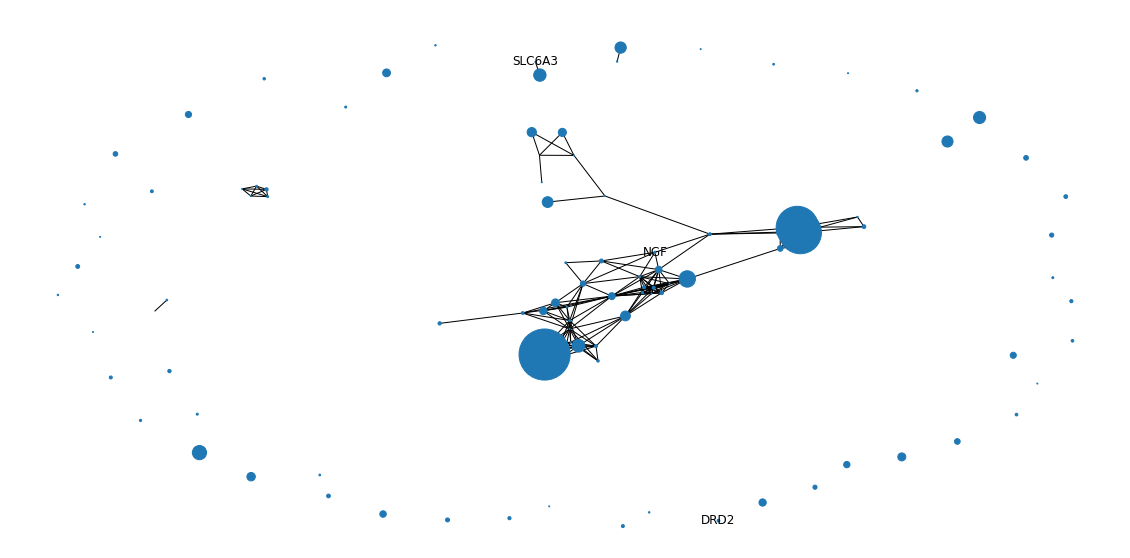

In [31]:
seed = 42
pos = nx.spring_layout(G, seed = seed)

# Set the figure size
plt.figure(figsize=(20, 10))

# Draw the graph using draw_networkx
nx.draw_networkx(G,
                 pos=pos,
                 node_size=sizes, with_labels=True,
                 labels={node: node if node in nodes_to_label else '' for node in G.nodes()})

# Hide the axis
plt.axis('off')

# Show the plot inline in Jupyter Lab
%matplotlib inline
plt.show()

In [32]:
# Define the target node
target_node = 'NGF'

In [33]:
# Calculate cosine similarity between the target node and all other nodes
target_similarity = {node: cosine_similarity(tfidf_matrix[log_reg_selected_features.index[log_reg_selected_features['gene_symbol'] == target_node]],
                                              tfidf_matrix[log_reg_selected_features.index[log_reg_selected_features['gene_symbol'] == node]])[0, 0]
                     for node in G.nodes}

In [34]:
# Sort nodes based on similarity in descending order
sorted_nodes = sorted(G.nodes, key=lambda x: target_similarity[x], reverse=True)


In [35]:
# Get the most relevant nodes (excluding the target node itself)
most_relevant_nodes = sorted_nodes[1:]

In [36]:
# Print the list of most relevant nodes compared to the target node
print("Most relevant nodes compared to", target_node, ":", most_relevant_nodes)

Most relevant nodes compared to NGF : ['LOC642969', 'MIF-AS1', 'CA12', 'LOC554206', 'LOC105374475', 'LOC101927779', 'PPATP2', 'LOC645626', 'LINC01538', 'ZNF884P', 'LOC105372730', 'SNORD3B-2', 'SNORD3B-1', 'LOC644110', 'FPGT-TNNI3K', 'LOC105371280', 'OR2T4', 'LOC101805491', 'ADGRF5P1', 'LOC105372700', 'LOC102724238', 'LOC105370428', 'LOC101927207', 'RNU6V', 'LOC105370598', 'GGT6', 'OR52Q1P', 'LOC105369427', 'RPL3P3', 'LINC01043', 'STRA13', 'LOC401913', 'LOC100292922', 'BMS1P8', 'RNVU1-8', 'LOC105379189', 'SLC6A3', 'LOC728433', 'PKD1P5', 'ACTL8', 'ANKRD20A17P', 'LINC01213', 'LOC100129358', 'LOC105377611', 'LOC105374974', 'RPS28', 'MSX2P1', 'PSMC1P12', 'LOC105379133', 'LOC101060179', 'LINC01231', 'TMIGD2', 'LOC102724318', 'LOC100129370', 'COL6A5', 'LOC105373627', 'LOC105376211', 'LOC105369807', 'LOC105377613', 'LOC100129860', 'KRT8P38', 'LOC100131013', 'LINC01091', 'TNNT1', 'LOC102724139', 'POTEA', 'NPIPA8', 'KRT77', 'ZG16B', 'LIPC', 'GBP4', 'SNORD110', 'LOC105378805', 'C1orf229', 'SLC35D

In [34]:
##################################################